In [191]:
import glob,re,pickle,operator,math
import string
from nltk.tokenize import sent_tokenize
from rouge import Rouge 
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import wordnet
import matplotlib.pyplot as plt 
from preprocessor.api import clean, tokenize, parse

algos = ('cosine similarity', 'Text Rank', 'Hybrid', 'Probability Based')
Y_len = np.arange(len(algos))
r1_scores=[]
r2_scores=[]
rl_scores=[]
recall=[]
precision=[]

In [192]:
def cosine_similarity_based(text):
    text=text.lower()
    text=clean(text)
    text=re.sub("&amp;",'',text)
    #preprocessing and (removal of useranme and url)
    hold =re.sub('^https?:\/\/.*[\r\n]*', '', text)
    username_removed = re.sub('@[^\s]+', '', hold)
    text=username_removed
    sentences=sent_tokenize(text)
    sentences2=[]
    for sentence in sentences:
        hold =re.sub('^https?:\/\/.*[\r\n]*', '', sentence)
        username_removed = re.sub('@[^\s]+', '', hold)
        sentences2.append(username_removed)
    
    sentences=sentences2
        
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)
    cosine_matrix=cosine_similarity(X)
    score_dict={}
    sentence_dict={}
    i=0
    for row in cosine_matrix:
        val=sum(row)
        score_dict[i]=val
        sentence_dict[i]=sentences[i]
        i+=1
    
    #sorting the score of the matrix
    sorted_dict=dict((sorted(score_dict.items(), key =operator.itemgetter(1), reverse=True)))
    
    summary=""
    k=1
    for i in sorted_dict:
        sentence=sentence_dict[i]
        summary+=sentence
        if(k==10):
            break
        k+=1
    
    return summary
    
    
        
    

In [193]:
#applying cosine_similarity algorithm on texts one by one (Baseline)
filelist1=sorted(glob.glob(r"/home/zartab/Documents/IR/IR_Project/Dataset_Project/Dataset/*"))
#print(filelist1)
sum_score_r1=0
sum_score_r2=0
sum_score_r3=0
sum_recall=0
sum_pre=0
for filename in filelist1:
    filelist2=sorted(glob.glob(filename+"/*"))
    train_path=filelist2[0]
    fp=open(train_path,"r",encoding="utf-8")
    train_text=fp.read()
    fp.close()
    summary=cosine_similarity_based(train_text)
    rouge = Rouge()
    test_path2=filelist2[2]
    fp=open(test_path2,"r",encoding="utf-8",errors="ignore")
    test_text2=fp.read()
    test_text2=test_text2.lower()
    fp.close()
    scores2 = rouge.get_scores(summary, test_text2)
    sum_score_r1+=scores2[0]['rouge-1']['f']
    sum_score_r2+=scores2[0]['rouge-2']['f']
    sum_score_r3+=scores2[0]['rouge-l']['f']
    sum_recall+=scores2[0]['rouge-1']['r']
    sum_pre+=scores2[0]['rouge-1']['p']
    
#     #print(scoresA)
    
    #print(summary)
    
print("Final R-1 R-2 R-L scores are : ",sum_score_r1/len(filelist1),sum_score_r2/len(filelist1),sum_score_r3/len(filelist1))
print("Precision Score : ",sum_pre/len(filelist1))
print("Recall Score : ",sum_recall/len(filelist1))
r1_scores.append(sum_score_r1/len(filelist1))
r2_scores.append(sum_score_r2/len(filelist1))
rl_scores.append(sum_score_r3/len(filelist1))
precision.append(sum_pre/len(filelist1))
recall.append(sum_recall/len(filelist1))
    

Final R-1 R-2 R-L scores are :  0.4113202908124819 0.30138574710362864 0.4502321752262154
Precision Score :  0.33614319143213317
Recall Score :  0.5837014158087395


In [194]:
def textrank(text):
    text=text.lower()
    text=clean(text)
    text=re.sub("&amp;",'',text)
    sentences=sent_tokenize(text)
    #print(len(sentences))
    dict_sentences={}
    i=0;
    for sentence in sentences:
        #removing URL
        hold = re.sub('^https?:\/\/.*[\r\n]*', '', sentence)
        username_removed = re.sub('@[^\s]+', '', hold)
        dict_sentences[i]=username_removed
        i+=1
    #print((dict_sentences))
    
    #removing hashtags(cleaning)
    data=sentences
    #data=sentences
    data2=[]
    for sentence in data:
        hold = re.sub('^https?:\/\/.*[\r\n]*', '', sentence)
        username_removed = re.sub('@[^\s]+', '', hold)
        word_list=word_tokenize(username_removed)
        sentence2=" "
        word_list2=[word_list[i] for i in range(len(word_list)) if i !=0 and word_list[i-1]!="#"]
        word_list2=[word for word in word_list2 if word!="#"]
        for word in word_list2:
            sentence2+=" "+word
        data2.append(sentence2)
        
        
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data2)
    #print((vectorizer.get_feature_names()))
    #print(X)
    cosine_matrix2=cosine_similarity(X)
    G=nx.from_numpy_matrix(cosine_matrix2)
    score=nx.pagerank(G,tol=1e-4,max_iter=300)
    
    
    
    sorted_dict=dict((sorted(score.items(), key =operator.itemgetter(1), reverse=True)))
    
    summary=""
    k=1
    for i in sorted_dict:
        sentence=dict_sentences[i]
        summary+=sentence
        if(k==10):
            break
        k+=1

    #print(summary)
    return summary
    
    

    
    

In [195]:
#applying textrank algorithm 
filelist1=sorted(glob.glob(r"/home/zartab/Documents/IR/IR_Project/Dataset_Project/Dataset/*"))
#print(filelist1)
sum_score_r1=0
sum_score_r2=0
sum_score_r3=0
sum_recall=0
sum_pre=0
for filename in filelist1:
    filelist2=sorted(glob.glob(filename+"/*"))
    train_path=filelist2[0]
    fp=open(train_path,"r",encoding="utf-8")
    train_text=fp.read()
    fp.close()
    summary=textrank(train_text)
    rouge = Rouge()
    test_path2=filelist2[2]
    fp=open(test_path2,"r",encoding="utf-8",errors="ignore")
    test_text2=fp.read()
    test_text2=test_text2.lower()
    fp.close()
    scores2 = rouge.get_scores(summary, test_text2)
    sum_score_r1+=scores2[0]['rouge-1']['f']
    sum_score_r2+=scores2[0]['rouge-2']['f']
    sum_score_r3+=scores2[0]['rouge-l']['f']
    sum_recall+=scores2[0]['rouge-1']['r']
    sum_pre+=scores2[0]['rouge-1']['p']
#     #print(scoresA)
    
#     #print(summary)
print("Final R-1 R-2 R-L scores are : ",sum_score_r1/len(filelist1),sum_score_r2/len(filelist1),sum_score_r3/len(filelist1))
print("Precision Score : ",sum_pre/len(filelist1))
print("Recall Score : ",sum_recall/len(filelist1))
r1_scores.append(sum_score_r1/len(filelist1))
r2_scores.append(sum_score_r2/len(filelist1))
rl_scores.append(sum_score_r3/len(filelist1))
precision.append(sum_pre/len(filelist1))
recall.append(sum_recall/len(filelist1))

Final R-1 R-2 R-L scores are :  0.429970194256755 0.31464774062763856 0.4729847659811698
Precision Score :  0.3416217476218165
Recall Score :  0.6111300763447731


In [196]:
def hybrid_algorithm(text):
    text=text.lower()
    text=clean(text)
    text=re.sub("&amp;",'',text)
    sentences=sent_tokenize(text)
    #print(len(sentences))
    dict_sentences={}
    i=0;
    vocab=[]
    for sentence in sentences:
        #removing URL
        hold = re.sub('^https?:\/\/.*[\r\n]*', '', sentence)
        username_removed = re.sub('@[^\s]+', '', hold)
        dict_sentences[i]=username_removed
        i+=1
    #print((dict_sentences))
    
    #removing hashtags(cleaning)
    data=sentences
    #data=sentences
    data2=[]
    for sentence in data:
        hold = re.sub('^https?:\/\/.*[\r\n]*', '', sentence)
        username_removed = re.sub('@[^\s]+', '', hold)
        word_list=word_tokenize(username_removed)
        sentence2=" "
        word_list2=[word_list[i] for i in range(len(word_list)) if i !=0 and word_list[i-1]!="#"]
        word_list2=[word for word in word_list2 if word!="#"]
        for word in word_list2:
            sentence2+=" "+word
            vocab.append(word)
        data2.append(sentence2)
        
    vocab=set(vocab)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data2)
    #print((vectorizer.get_feature_names()))
    #print(X)
    cosine_matrix2=cosine_similarity(X)
    G=nx.from_numpy_matrix(cosine_matrix2)
    score=nx.pagerank(G,tol=1e-4,max_iter=300)
    
    
    #imp feature extraction on the basis of idf values
    n=len(sentences)
    idf_dict={}
    for word in vocab:
        count=0
        for sentence in sentences:
            word_list=word_tokenize(sentence)
            if word in word_list:
                count+=1
        idf=n/(1+count)
        idf=math.log(idf)
        idf_dict[word]=idf
         
    #pos tagging for vocabulary
    tag_vocab=nltk.pos_tag(word_list)
    pos_tag_dict_word={}
    for tup in tag_vocab:
        pos_tag_dict_word[tup[0]]=tup[1]
    
    sorted_idf=dict((sorted(idf_dict.items(), key =operator.itemgetter(1), reverse=True)))
    #top 10 idf words are important so adding extra score on basis of feature words
    top_10_dict={}
    i=1
    for word in sorted_idf:
        top_10_dict[word]=sorted_idf[word]
        if(i==10):
            break
        i+=1
        
    #pos scoring of sentences
    for i in range(0,len(dict_sentences)):
        sentence=dict_sentences[i]
        word_list=word_tokenize(sentence)
        tagged=nltk.pos_tag(word_list)
        
        if(len(word_list)>10):
            score[i]+=0.5
        
        for tup in tagged:
            if(tup[1]=="NN" or tup[1]=="NNP" or tup[1]=="NNS" or tup[1]=="NNPS"):
                score[i]+=0.4
            
            if(tup[1]=="JJ" or tup[1]=="JJR" or tup[1]=="JJS"):
                score[i]+=0.4
            
            #calculating synset based similarity between top features 
            for word in top_10_dict:
                if(word in pos_tag_dict_word and pos_tag_dict_word[word]==tup[1]):
            
                    hold1=wordnet.synsets(word)
                    hold=wordnet.synsets(tup[0])
                    if(len(hold)>0 and len(hold1)>0):
                        syn1=wordnet.synsets(word)[0]
                        syn2=wordnet.synsets(tup[0])[0]
                        sim=syn1.wup_similarity(syn2)
                        if(sim!=None):
                            score[i]+=sim
            
                
        for word in word_list:
             if word in top_10_dict:
                score[i]+=0.2
                
        
        
    
    
    sorted_dict=dict((sorted(score.items(), key =operator.itemgetter(1), reverse=True)))
    
    summary=""
    k=1
    for i in sorted_dict:
        sentence=dict_sentences[i]
        summary+=sentence
        if(k==10):
            break
        k+=1

    #print(summary)
    return summary

    

In [197]:
#applying Hybrid algorithm on texts one by one
filelist1=sorted(glob.glob(r"/home/zartab/Documents/IR/IR_Project/Dataset_Project/Dataset/*"))
#print(filelist1)
sum_score_r1=0
sum_score_r2=0
sum_score_r3=0
sum_recall=0
sum_pre=0
for filename in filelist1:
    filelist2=sorted(glob.glob(filename+"/*"))
    train_path=filelist2[0]
    fp=open(train_path,"r",encoding="utf-8")
    train_text=fp.read()
    fp.close()
    summary=hybrid_algorithm(train_text)
    rouge = Rouge()
    test_path2=filelist2[2]
    fp=open(test_path2,"r",encoding="utf-8",errors="ignore")
    test_text2=fp.read()
    test_text2=test_text2.lower()
    fp.close()
    scores2 = rouge.get_scores(summary, test_text2)
    sum_score_r1+=scores2[0]['rouge-1']['f']
    sum_score_r2+=scores2[0]['rouge-2']['f']
    sum_score_r3+=scores2[0]['rouge-l']['f']
    sum_recall+=scores2[0]['rouge-1']['r']
    sum_pre+=scores2[0]['rouge-1']['p']
#     #print(scoresA)
    
#     #print(summary)
print("Final R-1 R-2 R-L scores are : ",sum_score_r1/len(filelist1),sum_score_r2/len(filelist1),sum_score_r3/len(filelist1))
print("Precision Score : ",sum_pre/len(filelist1))
print("Recall Score : ",sum_recall/len(filelist1))
r1_scores.append(sum_score_r1/len(filelist1))
r2_scores.append(sum_score_r2/len(filelist1))
rl_scores.append(sum_score_r3/len(filelist1))
precision.append(sum_pre/len(filelist1))
recall.append(sum_recall/len(filelist1))

Final R-1 R-2 R-L scores are :  0.461300491153276 0.3730424747070153 0.493692050975321
Precision Score :  0.332107120595606
Recall Score :  0.7731132061327274


In [198]:
def Probability_Based(text):
    text=text.lower()
    text=clean(text)
    text=re.sub("&amp;",'',text)
    #removing URL
    hold = re.sub('^https?:\/\/.*[\r\n]*', '', text)
    #removing username
    username_removed = re.sub('@[^\s]+', '', hold)
    sentences=sent_tokenize(username_removed)
    vocab={}
    words=word_tokenize(username_removed)
    for word in words:
        if word in vocab:
            vocab[word]+=1
        else:
            vocab[word]=1
    
    dict_sentences={}
    i=0
    for sentence in sentences:
        dict_sentences[i]=username_removed
        i+=1
            
    
    #finding features first
    idf_dict={}
    n=len(sentences)
    for word in vocab:
        df=0
        for sentence in sentences:
            word_sent=word_tokenize(sentence)
            if word in set(word_sent):
                df+=1
                
        idf=(n/(1+df))
        math.log(1+idf)
        idf_dict[word]=idf
    
    
    #probability of word occurence
    prob_word={}
    total=sum(vocab.values())
    for word in vocab:
        count_word=vocab[word]
        pro=count_word/total
        prob_word[word]=pro
    
    #sentence scoring 
    sent_score={}
    for sentence in sentences:
        words_sent=word_tokenize(sentence)
        score_sent=0
        for word in word_sent:
            score_sent+=prob_word[word]
            score_sent+=idf_dict[word]
            
        sent_score[sentence]=score_sent
    
    sorted_dict=dict((sorted(sent_score.items(), key =operator.itemgetter(1), reverse=True)))
    
    summary=""
    k=1
    for sent in sorted_dict:
        sentence=sent
        summary+=sentence
        if(k==10):
            break
        k+=1

    #print(summary)
    return summary
        
            
            
    

In [199]:
#applying Probability Based algorithm on texts one by one
filelist1=sorted(glob.glob(r"/home/zartab/Documents/IR/IR_Project/Dataset_Project/Dataset/*"))
#print(filelist1)
sum_score_r1=0
sum_score_r2=0
sum_score_r3=0
sum_recall=0
sum_pre=0
for filename in filelist1:
    filelist2=sorted(glob.glob(filename+"/*"))
    train_path=filelist2[0]
    fp=open(train_path,"r",encoding="utf-8")
    train_text=fp.read()
    fp.close()
    summary=Probability_Based(train_text)
    rouge = Rouge()
    test_path2=filelist2[2]
    fp=open(test_path2,"r",encoding="utf-8",errors="ignore")
    test_text2=fp.read()
    fp.close()
    scores2 = rouge.get_scores(summary, test_text2)
    sum_score_r1+=scores2[0]['rouge-1']['f']
    sum_score_r2+=scores2[0]['rouge-2']['f']
    sum_score_r3+=scores2[0]['rouge-l']['f']
    sum_recall+=scores2[0]['rouge-1']['r']
    sum_pre+=scores2[0]['rouge-1']['p']
#     #print(scoresA)
print("Final scores are : ",sum_score_r1/len(filelist1),sum_score_r2/len(filelist1),sum_score_r3/len(filelist1))
print("Precision Score : ",sum_pre/len(filelist1))
print("Recall Score : ",sum_recall/len(filelist1))
r1_scores.append(sum_score_r1/len(filelist1))
r2_scores.append(sum_score_r2/len(filelist1))
rl_scores.append(sum_score_r3/len(filelist1))
precision.append(sum_pre/len(filelist1))
recall.append(sum_recall/len(filelist1))


Final scores are :  0.43296196762226147 0.316655308439052 0.4459821719554739
Precision Score :  0.3936091765305796
Recall Score :  0.5007971524459409


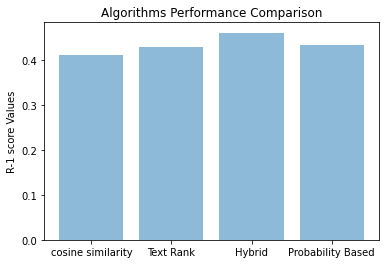

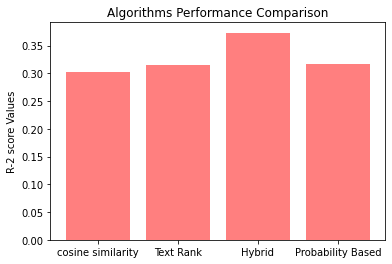

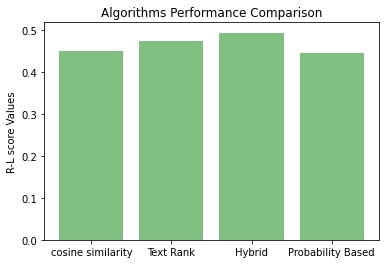

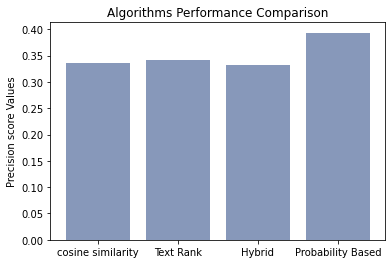

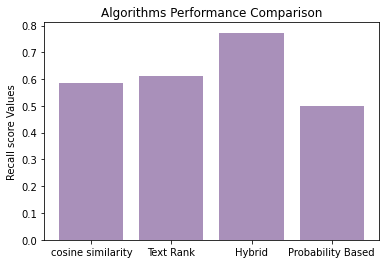

In [200]:
#plotting the bar graphs for comparison
plt.bar(Y_len, r1_scores, align='center', alpha=0.5)
plt.xticks(Y_len, algos)
plt.ylabel('R-1 score Values')
plt.title('Algorithms Performance Comparison')

plt.show()
plt.bar(Y_len, r2_scores, align='center',color="r", alpha=0.5)
plt.xticks(Y_len, algos)
plt.ylabel('R-2 score Values')
plt.title('Algorithms Performance Comparison')
plt.show()

plt.bar(Y_len, rl_scores, align='center',color="g", alpha=0.5)
plt.xticks(Y_len, algos)
plt.ylabel('R-L score Values')
plt.title('Algorithms Performance Comparison')
plt.show()

plt.bar(Y_len, precision, align='center',color="#113377", alpha=0.5)
plt.xticks(Y_len, algos)
plt.ylabel('Precision score Values')
plt.title('Algorithms Performance Comparison')
plt.show()

plt.bar(Y_len, recall, align='center', color="#542277",alpha=0.5)
plt.xticks(Y_len, algos)
plt.ylabel('Recall score Values')
plt.title('Algorithms Performance Comparison')
plt.show()

In [201]:
#Live Streaming tweets on topic of dataset and creating summary
import tweepy
import credentials

auth = tweepy.OAuthHandler(credentials.CONSUMER_KEY, credentials.CONSUMER_SECRET)
auth.set_access_token(credentials.ACCESS_TOKEN, credentials.ACCESS_TOKEN_SECRET )

api = tweepy.API(auth)


In [202]:
#If you want to search for tweets type the keyword ap.search("keyword here",...)
#keeping rest part same or vary the count
fetch_tweets=api.search("coronavirus", lang="en", tweet_mode='extended' ,count = 20)
print(len(fetch_tweets))

20


In [203]:
tweet_dict={}
corpus=[]
for tweet in fetch_tweets:
    if "retweeted_status" in tweet._json:
        #print(tweet._json["retweeted_status"]["full_text"])
        if tweet._json["retweeted_status"]["full_text"] not in tweet_dict:
            tweet_dict[tweet._json["retweeted_status"]["full_text"]]=1
            corpus.append(tweet._json["retweeted_status"]["full_text"])
        #print(tweet._json["retweet_count"])
        
    else:
        #print(tweet.full_text)
        if tweet.full_text not in tweet_dict:
            tweet_dict[tweet.full_text]=1
            corpus.append(tweet.full_text)
       # print(tweet.retweet_count)
    

In [209]:

def generatecloud(text):
    main_words =text 
    stopwords = set(STOPWORDS) 
    stopwords.add("https")
    wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(main_words) 
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

In [210]:
tweet_text=""
for tweet in tweet_dict:
    tweet_text+=tweet
    

places without social distancing have times more likely coronavirus spread, study finds in: u.s. retail sales fell % in april, even worse than the previous record decline in march you remember johnson and the tories boasting about how many rough sleepers they’ve taken off the streets during the coronavirus crisis?they’ve quietly pulled the funding for it.if you thought we had a rough sleeping crisis before, it’s going to get a whole lot worse.the advice in wales has not changed: if you can, please stay home to save lives.all holiday accommodations and attractions in wales are closed.please do not travel at this time.by following this advice , you are saving lives.taylor was an “essential worker” during the early days of the coronavirus pandemic.she deserved an america that saw her as essential before it called her a hero.my latest for , on the young emt shot to death by louisville police.giving one deserving person £200 towards anything they need.


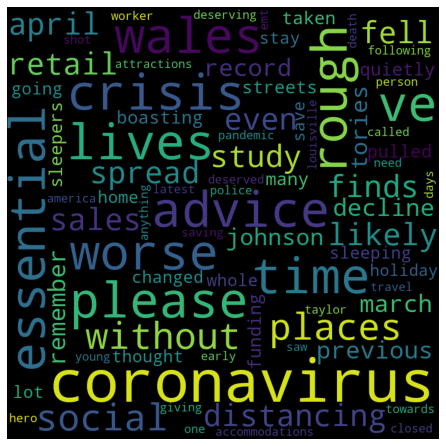

In [211]:
summary=Probability_Based(tweet_text)


print(summary)
generatecloud((summary))



In [207]:
#Graph of tweets
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
#print(len(vectorizer.get_feature_names()))
cosine_matrix=cosine_similarity(X)
#print(cosine_matrix[0])/''

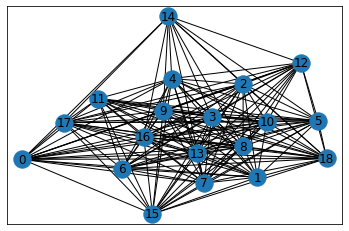

In [208]:
G=nx.from_numpy_matrix(cosine_matrix)
#print(G.edges(data=True))
pos= nx.spring_layout(G)
nx.draw_networkx(G, pos=None, arrows=True, with_labels=True)
plt.show()
# nx.draw(G,pos)
# # plt.draw()
# labels = nx.get_edge_attributes(G,'weight')
# # #print(labels)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)